In [3]:
import math, time
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

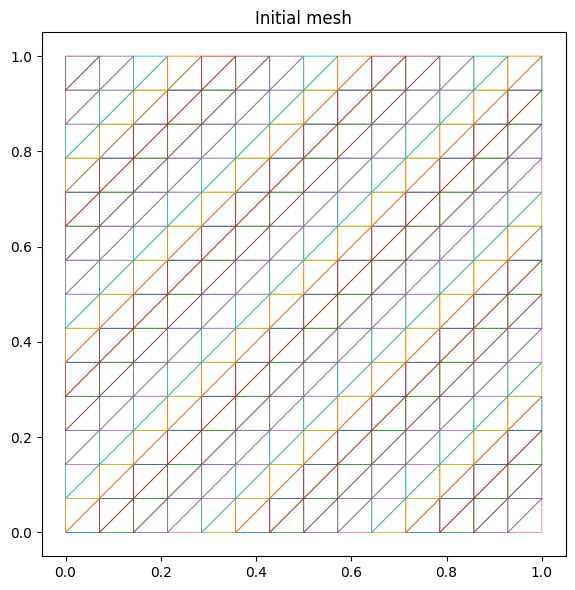

In [4]:
# mesh generation

def generate_unit_square_mesh(nx=16, ny=16):
    xs = np.linspace(0.0, 1.0, nx+1)
    ys = np.linspace(0.0, 1.0, ny+1)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    nodes = np.column_stack([X.ravel(), Y.ravel()])

    def vid(i, j): return j*(nx+1) + i

    tris = []
    for j in range(ny):
        for i in range(nx):
            v00 = vid(i, j); v10 = vid(i+1, j)
            v01 = vid(i, j+1); v11 = vid(i+1, j+1)

            # split each quad into two triangles
            tris.append([v00, v10, v11])
            tris.append([v00, v11, v01])
    return nodes, np.array(tris, dtype=np.int64)

# smoke test and a tiny plot
def plot_mesh(nodes, tris, title="Mesh"):
    plt.figure(figsize=(6,6))
    for t in tris:
        xy = nodes[t]
        px = np.append(xy[:,0], xy[0,0])
        py = np.append(xy[:,1], xy[0,1])
        plt.plot(px, py, linewidth=0.6)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.tight_layout()
    plt.show()

nodes, tris = generate_unit_square_mesh(14, 14)
plot_mesh(nodes, tris, "Initial mesh")


In [6]:
# element formulas and global assembly

def tri_area_and_B(coords):
    x1,y1 = coords[0]; x2,y2 = coords[1]; x3,y3 = coords[2]
    detJ = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)
    area = 0.5*abs(detJ)
    sgn = np.sign(detJ) if detJ != 0 else 1.0
    b1 = np.array([y2-y3, x3-x2])/(2.0*area)*sgn
    b2 = np.array([y3-y1, x1-x3])/(2.0*area)*sgn
    b3 = np.array([y1-y2, x2-x1])/(2.0*area)*sgn
    B = np.column_stack([b1,b2,b3])

def local_stiffness(coords):
    area, B = tri_area_and_B(coords)
    return area*(B.T @ B), area

def local_load(coords, f):
    area, _ = tri_area_and_B(coords)
    xc, yc = coords[:,0].mean(), coords[:,1].mean()
    return np.full(3, f(xc, yc)*area/3.0)

def assemble_system(nodes, tris, f):
    n = len(nodes)
    K = lil_matrix((n, n), dtype=float)
    b = np.zeros(n, dtype=float)
    for t in tris:
        coords = nodes[t]
        Ke, _ = local_stiffness(coords)
        be = local_load(coords, f)
        for a,A in enumerate(t):
            b[A] += be[a]
            for c,C in enumerate(t):
                K[A, C] += Ke[a, c]
    return K.tocsr(), b

# RHS for Poisson
def f_rhs(x, y):
    return 10.0*math.sin(math.pi*x)*math.sin(math.pi*y)


In [7]:
# boundary nodes

def dirichlet_mask(nodes, tol=1e-12):
    x = nodes[:,0]; y = nodes[:,1]
    return (np.abs(x) < tol) | (np.abs(x-1) < tol) | (np.abs(y) < tol) | (np.abs(y-1) < tol)

def apply_dirichlet(K, b, mask, g=None):
    n = K.shape[0]
    if g is None: g = np.zeros(n)
    K = K.tolil()
    idx = np.where(mask)[0]
    for i in idx:
        K.rows[i] = [i]
        K.data[i] = [1.0]
        b[i] = g[i]
    return K.tocsr(), b


In [8]:
# ZZ error estimator

def element_gradients(nodes, tris, u):
    M = len(tris)
    grads = np.zeros((M,2)); areas = np.zeros(M)
    for k,t in enumerate(tris):
        coords = nodes[t]
        area, B = tri_area_and_B(coords)
        grads[k] = B @ u[t]
        areas[k] = area
    return grads, areas

def recovered_nodal_grad(nodes, tris, grads):
    n = len(nodes)
    acc = np.zeros((n,2)); cnt = np.zeros(n, dtype=int)
    for k,t in enumerate(tris):
        g = grads[k]
        for v in t:
            acc[v] += g; cnt[v] += 1
    cnt[cnt==0] = 1
    return acc / cnt[:,None]

def zz_estimator(nodes, tris, u):
    grads, areas = element_gradients(nodes, tris, u)
    g_rec = recovered_nodal_grad(nodes, tris, grads)
    elem_err2 = np.zeros(len(tris))
    for k,t in enumerate(tris):
        gbar = (g_rec[t[0]] + g_rec[t[1]] + g_rec[t[2]]) / 3.0
        d = grads[k] - gbar
        elem_err2[k] = areas[k]*(d@d)
    return np.sqrt(elem_err2 + 1e-30), math.sqrt(elem_err2.sum())


In [9]:
# bulk marking

def bulk_mark(elem_err, theta=0.5):
    idx = np.argsort(-elem_err)
    tot = elem_err.sum(); target = theta*tot
    s = 0.0; marked = []
    for i in idx:
        s += elem_err[i]; marked.append(i)
        if s >= target: break
    return np.array(marked, dtype=int)


In [10]:
# some refinements

def _normalize_edge(a,b):
    return (a,b) if a<b else (b,a)

def _longest_edge(nodes, tri):
    i,j,k = tri
    edges = [(i,j),(j,k),(k,i)]
    lens2 = [np.sum((nodes[a]-nodes[b])**2) for (a,b) in edges]
    return edges[int(np.argmax(lens2))]

def refine_longest_edge(nodes, tris, marked):
    from collections import defaultdict, deque
    nodes = nodes.copy()
    tris  = tris.copy()


    edge2tris = defaultdict(list)
    for ti,t in enumerate(tris):
        for e in [(t[0],t[1]),(t[1],t[2]),(t[2],t[0])]:
            edge2tris[_normalize_edge(*e)].append(ti)


    will = np.zeros(len(tris), dtype=bool); will[marked] = True
    q = deque(marked.tolist())
    while q:
        ti = q.popleft()
        if ti < 0 or ti >= len(tris):
            continue
        t = tris[ti]
        e = _longest_edge(nodes, t)
        nbrs = edge2tris.get(_normalize_edge(*e), [])
        for tj in nbrs:
            if not will[tj]:
                will[tj] = True
                q.append(tj)

    # more refinement
    edge_mid = {}
    new_tris = []
    for ti,t in enumerate(tris):
        if not will[ti]:
            new_tris.append(t);
            continue
        i,j,k = t
        a,b = _longest_edge(nodes, t)
        c = [v for v in t if v not in (a,b)][0]
        ek = _normalize_edge(a,b)
        if ek in edge_mid:
            m = edge_mid[ek]
        else:
            pm = 0.5*(nodes[a] + nodes[b])
            m = len(nodes)
            nodes = np.vstack([nodes, pm])
            edge_mid[ek] = m
        new_tris.append([a,m,c])
        new_tris.append([m,b,c])

    return nodes, np.array(new_tris, dtype=np.int64)


In [12]:
# helper plot

from matplotlib.tri import Triangulation

def plot_scalar(nodes, tris, z, title):
    tri = Triangulation(nodes[:,0], nodes[:,1], tris)
    plt.figure(figsize=(6,5))
    plt.tricontourf(tri, z, levels=20)
    plt.colorbar()
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_convergence(dofs, errs, title="Convergence"):
    plt.figure(figsize=(6,4))
    plt.loglog(dofs, errs, marker='o')
    plt.xlabel("DOFs (nodes)")
    plt.ylabel("Estimated error (ZZ)")
    plt.title(title)
    plt.grid(True, which='both')
    plt.tight_layout()
    plt.show()


[Cycle 0] N=   225  Tris=   392  est_err=1.0101e-01  solve_time=0.001s


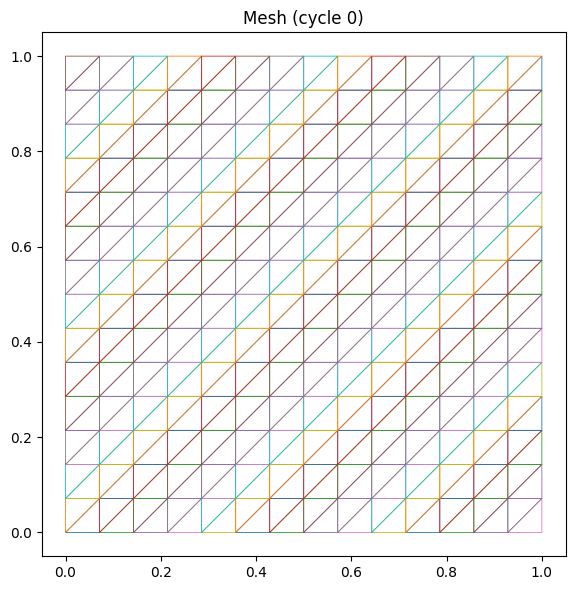

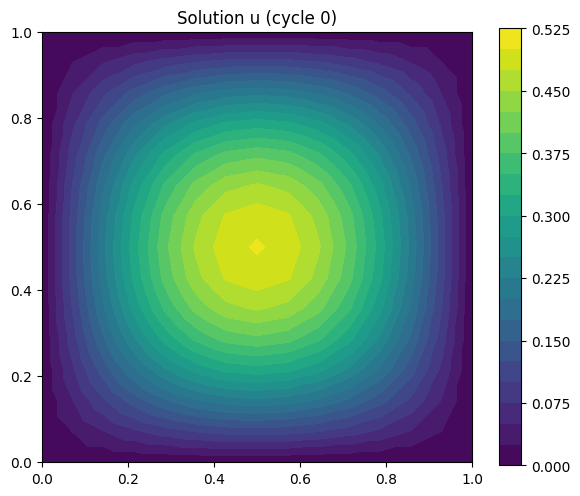

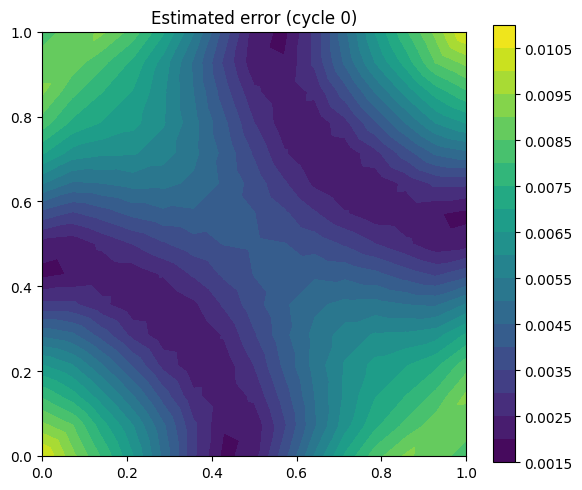

[Cycle 1] N=   295  Tris=   532  est_err=6.2374e-02  solve_time=0.001s


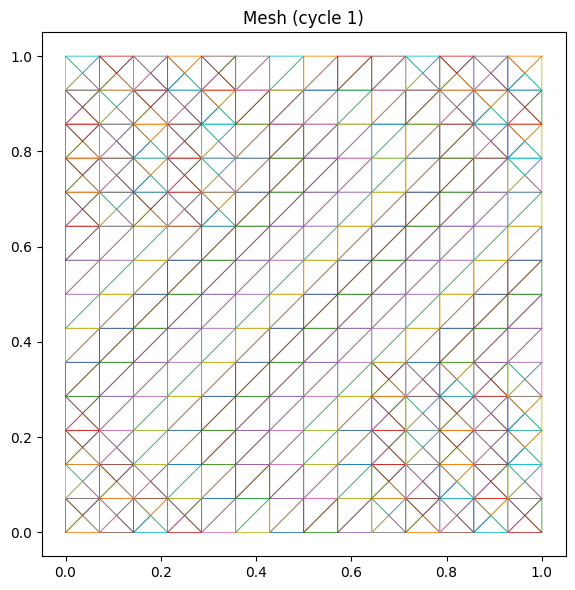

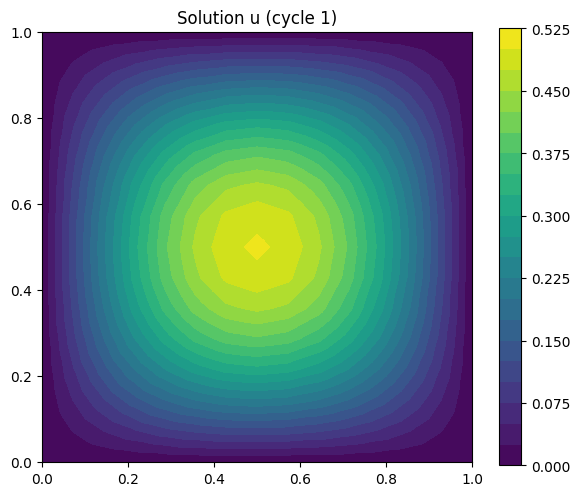

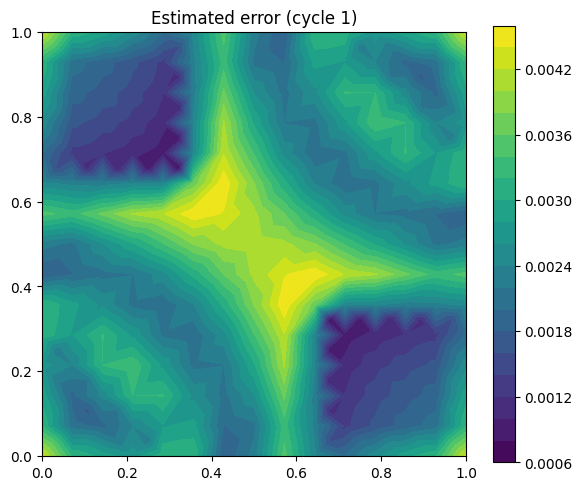

[Cycle 2] N=   401  Tris=   712  est_err=3.8713e-02  solve_time=0.002s


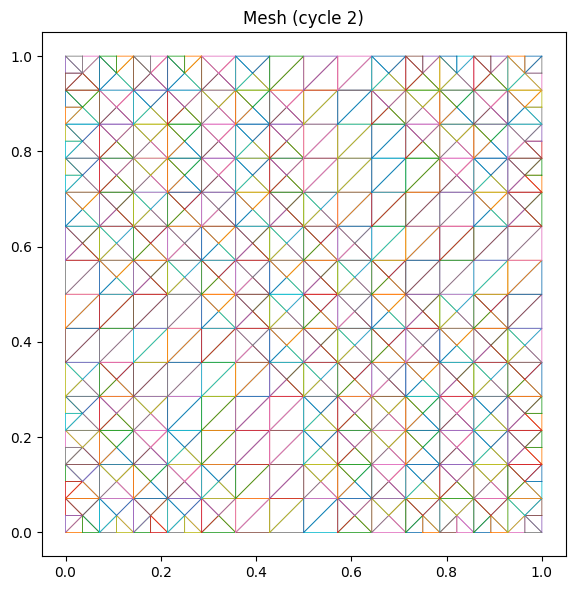

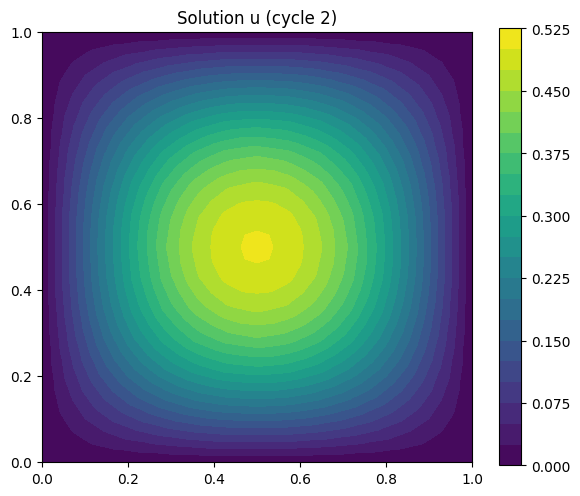

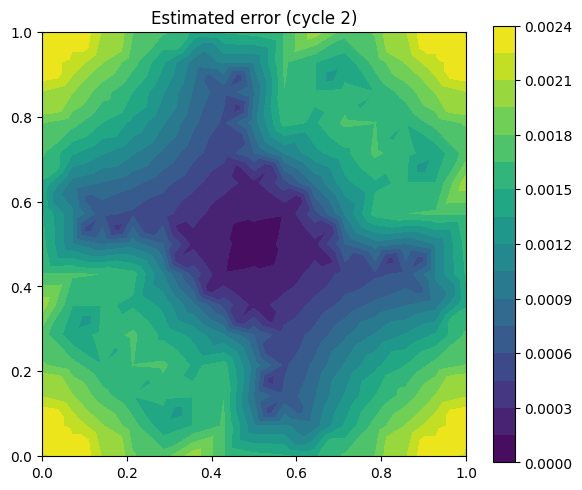

[Cycle 3] N=   588  Tris=  1021  est_err=7.6637e-02  solve_time=0.001s


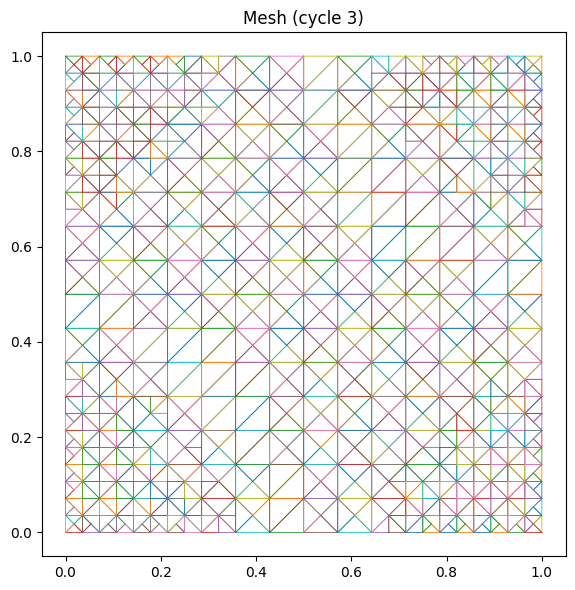

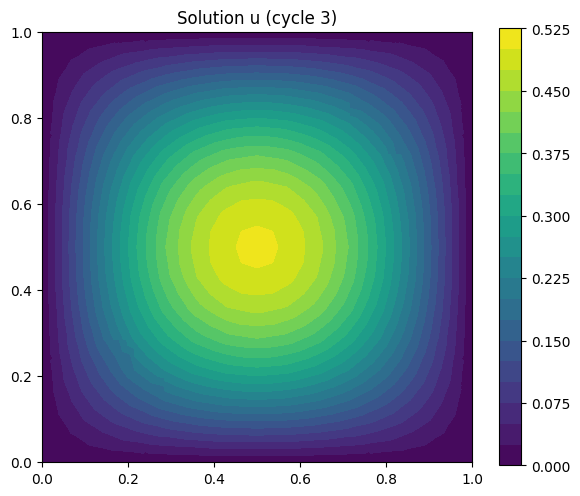

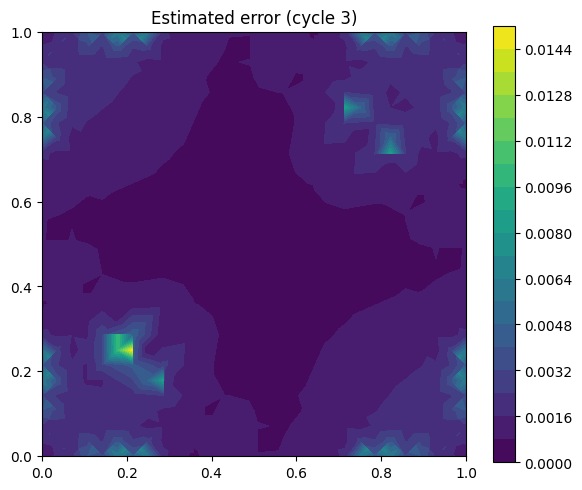

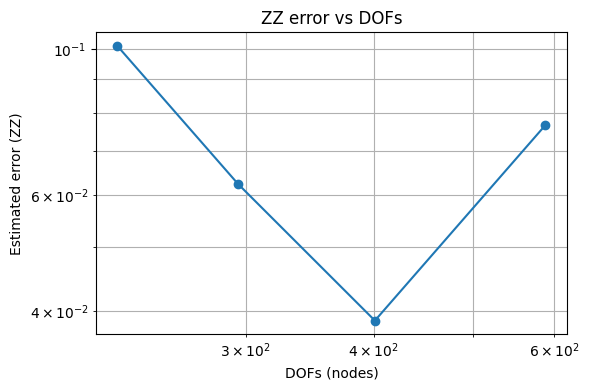

In [14]:
# adaptive loop

def adaptive_poisson(nx0=14, ny0=14, cycles=3, theta=0.5):
    nodes, tris = generate_unit_square_mesh(nx0, ny0)
    dofs_hist, err_hist = [], []

    for it in range(cycles+1):

        # assemble
        K, b = assemble_system(nodes, tris, f_rhs)

        # BCs
        mask = dirichlet_mask(nodes)
        K, b = apply_dirichlet(K, b, mask)

        # solve
        t0 = time.time()
        u = spsolve(K, b)
        tsolve = time.time() - t0

        # estimate error
        elem_err, total = zz_estimator(nodes, tris, u)
        dofs_hist.append(len(nodes)); err_hist.append(total)

        print(f"[Cycle {it}] N={len(nodes):6d}  Tris={len(tris):6d}  "
              f"est_err={total:.4e}  solve_time={tsolve:.3f}s")

        # plots for this cycle
        plot_mesh(nodes, tris, f"Mesh (cycle {it})")
        plot_scalar(nodes, tris, u, f"Solution u (cycle {it})")

        # vertex averaged error for display
        v_err = np.zeros(len(nodes)); cnt = np.zeros(len(nodes))
        for k,t in enumerate(tris):
            e = elem_err[k]
            for v in t:
                v_err[v] += e; cnt[v] += 1
        cnt[cnt==0] = 1
        v_err /= cnt
        plot_scalar(nodes, tris, v_err, f"Estimated error (cycle {it})")

        if it == cycles:
            break

        # mark and refine
        marked = bulk_mark(elem_err, theta=theta)
        nodes, tris = refine_longest_edge(nodes, tris, marked)

    plot_convergence(dofs_hist, err_hist, "ZZ error vs DOFs")
    return nodes, tris, u, dofs_hist, err_hist


nodes, tris, u, dofs_hist, err_hist = adaptive_poisson(nx0=14, ny0=14, cycles=3, theta=0.5)
